## 251_spatial_operations_studyarea.ipynb
<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"><b>This script selects all earthquakes for the complete study area with set buffers around volcanoes.</b> The main parts of the routines were developed in previous courses at the University of London by the same author (Mohr, 2021, 2023, 2024a) and have been further refined to meet the needs of this MSc thesis project/research. However, the code has been updated to comply with the latest requirements and package interdependencies. Some comments will be included in this Jupyter Notebook, and the code contains several inline comments. For details on the project/research itself, refer to the appropriate document.

#### References (for this script)
*Mohr, S. (2021) Regional Spatial Clusters of Earthquakes at the Pacific Ring of Fire: Analysing Data from the USGS ANSS ComCat and Building Regional Spatial Clusters. DSM020, Python, examined coursework cw1. University of London.*

*Mohr, S. (2023) Clustering of Earthquakes on a Worldwide Scale with the Help of Big Data Machine Learning Methods. DSM010, Big Data, examined coursework cw2. University of London.*

*Mohr, S. (2024a) Comparing Different Tectonic Setups Considering Publicly Available Basic Earthquake’s Data. DSM050, Data Visualisation, examined coursework cw1. University of London.*

#### History
<pre>
250119 Generation from a test script for spatial operations, setup basics, use parameters.py, make loop,
       save figures and datasets in directories per cluster, show infos while looping, protect script for
       running with wrong parameter section
250125 Integrating new version of save_dataset </pre>

#### Todo
<pre>./.</pre>

## Preparing the environment
### System information

In [1]:
# which python installation and version are we using here?
print('\n******* Python Info ***********')
!which python
!python --version

# show some CPU and RAM info
print('\n******* CPU Info ***********')
!lscpu
print('\n******* RAM Info (in GB) ***********')
!free -g


******* Python Info ***********
/bin/python
Python 3.8.10

******* CPU Info ***********
Architecture:                       x86_64
CPU op-mode(s):                     32-bit, 64-bit
Byte Order:                         Little Endian
Address sizes:                      46 bits physical, 48 bits virtual
CPU(s):                             64
On-line CPU(s) list:                0-63
Thread(s) per core:                 2
Core(s) per socket:                 8
Socket(s):                          4
NUMA node(s):                       4
Vendor ID:                          GenuineIntel
CPU family:                         6
Model:                              85
Model name:                         Intel(R) Xeon(R) Gold 6234 CPU @ 3.30GHz
Stepping:                           7
CPU MHz:                            1200.287
CPU max MHz:                        4000.0000
CPU min MHz:                        1200.0000
BogoMIPS:                           6600.00
Virtualization:                     VT-x
L1

In [2]:
# show installed packages and versions
!pip freeze

absl-py==2.1.0
affine==2.4.0
aggdraw==1.3.16
arch==5.6.0
array-record==0.4.0
astropy==5.2.2
asttokens==2.4.1
astunparse==1.6.3
atomicwrites==1.1.5
attrs==19.3.0
Automat==0.8.0
backcall==0.2.0
beautifulsoup4==4.12.3
blinker==1.4
branca==0.8.1
cachetools==5.5.0
certifi==2019.11.28
cftime==1.6.4.post1
chardet==3.0.4
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloud-init==24.3.1
clustpy==0.0.1
colorama==0.4.3
comm==0.2.2
command-not-found==0.3
configobj==5.0.6
confluent-kafka==2.5.3
constantly==15.1.0
contextily==1.5.2
contourpy==1.1.1
cryptography==2.8
cupshelpers==1.0
cycler==0.10.0
dbus-python==1.2.16
debugpy==1.8.7
decorator==4.4.2
defer==1.0.6
distro==1.4.0
distro-info==0.23+ubuntu1.1
dm-tree==0.1.8
dtw==1.4.0
entrypoints==0.3
et-xmlfile==1.0.1
etils==1.3.0
executing==2.0.1
fail2ban==0.11.1
fastjsonschema==2.20.0
filelock==3.13.1
fiona==1.9.6
flatbuffers==24.3.25
folium==0.18.0
fonttools==4.53.1
frites==0.4.4
fsspec==2023.12.2
ftfy==6.2.0
gast==0.4.0
geodatasets==2024.8.0
geographi

### Setting PATH correctly

In [3]:
# there is somewhere a PATH-error on LENA for a while
# adding my packages path to the PATH environment

import sys
sys.path.append("/home/smohr001/.local/lib/python3.8/site-packages")
sys.path

['/home/smohr001/thesis',
 '/usr/lib/python38.zip',
 '/usr/lib/python3.8',
 '/usr/lib/python3.8/lib-dynload',
 '',
 '/opt/jupyterhub/lib/python3.8/site-packages',
 '/opt/jupyterhub/lib/python3.8/site-packages/IPython/extensions',
 '/home/smohr001/.ipython',
 '/home/smohr001/.local/lib/python3.8/site-packages']

### Loading libraries

In [4]:
# importing standard libraries
import sys
import os
import warnings
import datetime
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import logging
from IPython.display import display, Javascript

# importing shared procedures for this procect (needs to be a simple .py file)
%run shared_procedures.py

import geopandas as gpd
from shapely import wkt
import geodatasets
from shapely.ops import unary_union

# get info about installed and used versions of some important (deep learning) libraries
print("Some important installed libraries:\n")
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Seaborn version: {sns.__version__}")

Some important installed libraries:

Pandas version: 1.4.1
Numpy version: 1.22.2
Seaborn version: 0.13.2


### Setting the script environment

In [5]:
# import the parameters (foreced to reload)
import parameters
import importlib
importlib.reload(parameters)

# print all loaded parameters from the Python file
print("Loaded Parameters:\n")
for key in dir(parameters):
    if not key.startswith("__"):
        value = getattr(parameters, key)
        print(f"parameters.{key} = {value}")

Loaded Parameters:

parameters.buffer_size_km = 1000
parameters.data_dir = data/scope/studyarea_1000
parameters.data_dir_raw = data
parameters.data_ts_dir = data/scope/studyarea_1000
parameters.scope_id = studyarea_1000


In [6]:
# protect THIS script from running with the wrong active parameter section
if(parameters.scope_id != "studyarea_1000"):
    logging.error(f"Active parameter section is NOT correct. Terminating!")
    sys.exit(1)
else:
    logging.info(f"Correct parameter section is active. Continuing.")    

In [7]:
# show all matplotlib graphs inline
%matplotlib inline

# setting format to JPG for easy copy & paste for figures
# for high quality outputs choose 'svg'
%config InlineBackend.figure_format = 'jpg'

# adjust display settings to show 20 rows as a standard
pd.set_option('display.max_rows', 20)

# disable warnings (activate after developing the complete code)
warnings.filterwarnings('ignore')

# set script (ipynb notebook) name (e.g. for logging)
script_name = "251_spatial_operations_studyarea.ipynb"

# start parameterized logging
setup_logging(logfile_dir = "log", 
              logfile_name = "25_spatial_operations.log", 
              log_level = logging.INFO, 
              script_name = script_name
             )

# set data directory
if(parameters.data_dir_raw):
    data_dir_raw = parameters.data_dir_raw
else:
    data_dir_raw = "data"
logging.info(f"{script_name}: Set raw data directory to './{data_dir_raw}'.")

if(parameters.data_dir):
    data_dir = parameters.data_dir
else:
    data_dir = "data"
logging.info(f"{script_name}: Set scope data directory to './{data_dir}'.")

if(parameters.data_dir):
    data_dir_ts = parameters.data_ts_dir
else:
    data_dir_ts = "data/timeseries"
logging.info(f"{script_name}: Set scope timeseries data directory to './{data_dir_ts}'.")

2025-01-28 13:08:55,156 - INFO - Starting script '251_spatial_operations_studyarea.ipynb'.
2025-01-28 13:08:55,157 - INFO - Set loglevel to INFO.
2025-01-28 13:08:55,158 - INFO - 251_spatial_operations_studyarea.ipynb: Set raw data directory to './data'.
2025-01-28 13:08:55,159 - INFO - 251_spatial_operations_studyarea.ipynb: Set scope data directory to './data/scope/studyarea_1000'.
2025-01-28 13:08:55,160 - INFO - 251_spatial_operations_studyarea.ipynb: Set scope timeseries data directory to './data/scope/studyarea_1000'.


In [8]:
# set fixed seed for reproducibility
reset_random_seeds(script_name=script_name)

2025-01-28 13:08:55,164 - INFO - 251_spatial_operations_studyarea.ipynb: Seeding random generators with seed=654321.


## Loading data

In [9]:
# load datasets
earthquakes_selected = load_dataset(data_file="earthquakes_selected.csv", data_dir=data_dir_raw)
volcanoes_selected = load_dataset(data_file="volcanoes_selected.csv", data_dir=data_dir_raw)
eruptions_selected = load_dataset(data_file="eruptions_selected.csv", data_dir=data_dir_raw)

2025-01-28 13:08:55,320 - INFO - load_dataset: Data loaded successfully from 'data/earthquakes_selected.csv'.
2025-01-28 13:08:55,324 - INFO - load_dataset: Data loaded successfully from 'data/volcanoes_selected.csv'.
2025-01-28 13:08:55,328 - INFO - load_dataset: Data loaded successfully from 'data/eruptions_selected.csv'.


## Statistics and information

In [10]:
# infos of the dataset
print("\nShape:\n" + str(volcanoes_selected.shape))
print("\nColumns and DataTypes:\n" + str(volcanoes_selected.dtypes))
display(volcanoes_selected)
logging.info(f"{script_name}: Used dataset is 'volcanoes_selected' with {volcanoes_selected.shape}.")

# infos of the dataset
print("\nShape:\n" + str(earthquakes_selected.shape))
print("\nColumns and DataTypes:\n" + str(earthquakes_selected.dtypes))
display(earthquakes_selected)
logging.info(f"{script_name}: Used dataset is 'earthquakes_selected' with {earthquakes_selected.shape}.")


Shape:
(201, 16)

Columns and DataTypes:
Volcano_Number            int64
geo_x                   float64
geo_y                   float64
Volcano_Name             object
Primary_Volcano_Type     object
Country                  object
Region                   object
Latitude                float64
Longitude               float64
Elevation                 int64
Tectonic_Setting         object
Evidence_Category        object
Major_Rock_Type          object
Erupting                   bool
Last_Activity_Year      float64
geometry                 object
dtype: object


,Volcano_Number,geo_x,geo_y,Volcano_Name,Primary_Volcano_Type,Country,Region,Latitude,Longitude,Elevation,Tectonic_Setting,Evidence_Category,Major_Rock_Type,Erupting,Last_Activity_Year,geometry
0,241040,177.1800,-37.5200,Whakaari/White Island,Stratovolcano(es),New Zealand,Tonga-Kermadec Volcanic Regions,-37.5200,177.1800,294,Subduction zone / Continental crust (> 25 km),Eruption Observed,Andesite / Basaltic Andesite,True,2019.0,POINT (177.18 -37.52)
1,241050,176.5069,-38.1569,Okataina,Lava dome(s),New Zealand,Tonga-Kermadec Volcanic Regions,-38.1569,176.5069,1111,Subduction zone / Continental crust (> 25 km),Eruption Observed,Rhyolite,True,1981.0,POINT (176.5069 -38.1569)
2,241080,175.6320,-39.1570,Tongariro,Stratovolcano(es),New Zealand,Tonga-Kermadec Volcanic Regions,-39.1570,175.6320,1978,Subduction zone / Continental crust (> 25 km),Eruption Observed,Andesite / Basaltic Andesite,True,2012.0,POINT (175.632 -39.157)
3,241100,175.5700,-39.2800,Ruapehu,Stratovolcano(es),New Zealand,Tonga-Kermadec Volcanic Regions,-39.2800,175.5700,2797,Subduction zone / Continental crust (> 25 km),Eruption Observed,Andesite / Basaltic Andesite,True,2007.0,POINT (175.57 -39.28)
4,242030,182.0800,-29.2700,Raoul Island,Stratovolcano(es),New Zealand,Tonga-Kermadec Volcanic Regions,-29.2700,-177.9200,516,Subduction zone / Oceanic crust (< 15 km),Eruption Observed,Andesite / Basaltic Andesite,True,2006.0,POINT (-177.92 -29.27)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,358041,287.3486,-42.8349,Chaiten,Caldera,Chile,South America Volcanic Regions,-42.8349,-72.6514,1122,Subduction zone / Continental crust (> 25 km),Eruption Observed,Rhyolite,True,2011.0,POINT (-72.6514 -42.8349)
197,358057,287.0300,-45.9000,"Hudson, Cerro",Stratovolcano(es),Chile,South America Volcanic Regions,-45.9000,-72.9700,1905,Subduction zone / Continental crust (> 25 km),Eruption Observed,Basalt / Picro-Basalt,True,2011.0,POINT (-72.97 -45.9)
198,358060,286.4960,-49.0190,Lautaro,Stratovolcano(es),Chile,South America Volcanic Regions,-49.0190,-73.5040,3542,Subduction zone / Continental crust (> 25 km),Eruption Observed,Dacite,True,1979.0,POINT (-73.504 -49.019)
199,284193,145.7800,16.5800,South Sarigan Seamount,Stratovolcano(es),United States,Northwest Pacific Volcanic Regions,16.5800,145.7800,-184,Subduction zone / Crustal thickness unknown,Eruption Observed,unknown,True,2010.0,POINT (145.78 16.58)


2025-01-28 13:08:55,347 - INFO - 251_spatial_operations_studyarea.ipynb: Used dataset is 'volcanoes_selected' with (201, 16).



Shape:
(63773, 20)

Columns and DataTypes:
id           object
geo_x       float64
geo_y       float64
timeymd      object
year          int64
lon         float64
lat         float64
depth       float64
mag         float64
time          int64
felt        float64
cdi         float64
mmi         float64
alert        object
status       object
tsunami       int64
nst           int64
net          object
sig         float64
geometry     object
dtype: object


,id,geo_x,geo_y,timeymd,year,lon,lat,depth,mag,time,felt,cdi,mmi,alert,status,tsunami,nst,net,sig,geometry
0,iscgem799554,276.6450,8.5430,1970-01-01,1970,-83.3550,8.5430,15.00,5.44,6226830,NaN,NaN,NaN,NaN,reviewed,0,455,iscgem,NaN,POINT (-83.355 8.543)
1,iscgem799588,182.8310,-29.4000,1970-01-01,1970,-177.1690,-29.4000,35.00,5.61,61860630,NaN,NaN,NaN,NaN,reviewed,0,484,iscgem,NaN,POINT (-177.169 -29.4)
2,iscgem799702,121.9190,0.3120,1970-01-04,1970,121.9190,0.3120,146.40,5.54,289882530,NaN,NaN,NaN,NaN,reviewed,0,472,iscgem,NaN,POINT (121.919 0.312)
3,iscgem799712,102.5430,24.1850,1970-01-04,1970,102.5430,24.1850,11.30,7.10,320441090,NaN,NaN,8.862,NaN,reviewed,0,776,iscgem,NaN,POINT (102.543 24.185)
4,iscgem799715,102.4390,24.1800,1970-01-04,1970,102.4390,24.1800,15.00,5.56,322359090,NaN,NaN,NaN,NaN,reviewed,0,476,iscgem,NaN,POINT (102.439 24.18)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63768,pr2019363002,293.1360,17.8846,2019-12-29,2019,-66.8640,17.8846,6.00,5.00,1577581560130,339.0,5.5,5.426,green,reviewed,0,571,pr,18.0,POINT (-66.864 17.8846)
63769,us70006s54,125.3963,4.6867,2019-12-29,2019,125.3963,4.6867,23.96,5.40,1577610735869,NaN,NaN,3.748,green,reviewed,0,449,us,NaN,POINT (125.3963 4.6867)
63770,us70006s6z,151.7733,-5.5011,2019-12-29,2019,151.7733,-5.5011,35.00,5.10,1577627942410,NaN,NaN,NaN,NaN,reviewed,0,400,us,NaN,POINT (151.7733 -5.5011)
63771,us70006sbu,142.8218,27.8371,2019-12-30,2019,142.8218,27.8371,17.30,5.10,1577679070184,1.0,3.4,NaN,NaN,reviewed,0,400,us,NaN,POINT (142.8218 27.8371)


2025-01-28 13:08:55,362 - INFO - 251_spatial_operations_studyarea.ipynb: Used dataset is 'earthquakes_selected' with (63773, 20).


## Setting correct datatypes

In [11]:
# define (target) data types for volcanoes
set_types_volcanoes = {'Volcano_Number': 'int64',
                       'Volcano_Name': 'object',
                       'Primary_Volcano_Type': 'object',
                       'Last_Activity_Year': 'int64',
                       'Country': 'object',
                       'Region': 'object',
                       'Latitude': 'float64',
                       'Longitude': 'float64',
                       'Elevation': 'int64',
                       'Tectonic_Setting': 'object',
                       'Evidence_Category': 'object',
                       'Major_Rock_Type': 'object'
                      }

# check and convert datatypes
print("Volcanoes checking.")
check_data_types_of_dataframe(volcanoes_selected, set_types_volcanoes)
print("\nVolcanoes correcting.")
volcanoes_enriched = convert_data_types_of_dataframe(volcanoes_selected, set_types_volcanoes)

Volcanoes checking.
Checking datatypes (no output means nothing to correct):

Last_Activity_Year: float64 --> int64

Volcanoes correcting.
Column 'Volcano_Number' converted to int64.
Column 'Volcano_Name' converted to object.
Column 'Primary_Volcano_Type' converted to object.
Column 'Last_Activity_Year' converted to int64.
Column 'Country' converted to object.
Column 'Region' converted to object.
Column 'Latitude' converted to float64.
Column 'Longitude' converted to float64.
Column 'Elevation' converted to int64.
Column 'Tectonic_Setting' converted to object.
Column 'Evidence_Category' converted to object.
Column 'Major_Rock_Type' converted to object.


In [12]:
#define (target) data types
set_types_earthquakes = {'geo_y': 'float64',
                         'geo_x': 'float64',
                         'lon': 'float64',
                         'lat': 'float64',
                         'depth': 'float64',
                         'mag': 'float64',
                         'time': 'int64',
                         'felt': 'float64',
                         'cdi': 'float64',
                         'mmi': 'float64',
                         'tsunami': 'int64',
                         'nst': 'int64',
                         'sig': 'float64',
                         'id': 'object',
                         'alert': 'object',
                         'status': 'object',
                         'net': 'object',
                         'year': 'int64',          # must be int64 for visualisation
                         'timeymd': 'datetime64',
                         'geometry': 'str'
                        }

# check and convert datatypes
print("Earthquakes checking.")
check_data_types_of_dataframe(earthquakes_selected, set_types_earthquakes)
print("\nEarthquakes correcting.")
earthquakes_enriched = convert_data_types_of_dataframe(earthquakes_selected, set_types_earthquakes)

Earthquakes checking.
Checking datatypes (no output means nothing to correct):

timeymd: object --> datetime64
geometry: object --> str

Earthquakes correcting.
Column 'geo_y' converted to float64.
Column 'geo_x' converted to float64.
Column 'lon' converted to float64.
Column 'lat' converted to float64.
Column 'depth' converted to float64.
Column 'mag' converted to float64.
Column 'time' converted to int64.
Column 'felt' converted to float64.
Column 'cdi' converted to float64.
Column 'mmi' converted to float64.
Column 'tsunami' converted to int64.
Column 'nst' converted to int64.
Column 'sig' converted to float64.
Column 'id' converted to object.
Column 'alert' converted to object.
Column 'status' converted to object.
Column 'net' converted to object.
Column 'year' converted to int64.
Column 'timeymd' converted to datetime64.
Column 'geometry' converted to str.


## Spatial operations

### Parameters

In [13]:
# set parameters
cluster_name = "all"

# set individual datadir for saving
data_dir_cluster = os.path.join(data_dir, "cluster_" + str(cluster_name))

# ensure data dir is in place
os.makedirs(data_dir_cluster, exist_ok=True)
logging.info(f"{script_name}: Set data directory for saving to './{data_dir_cluster}'.")

2025-01-28 13:08:55,413 - INFO - 251_spatial_operations_studyarea.ipynb: Set data directory for saving to './data/scope/studyarea_1000/cluster_all'.


### Preparation

In [14]:
# handling of spatial geometry point information (pre-applying the right format)
print("Columns 'geometry' pre-converted with WKT information (prepared for POINT conversion).")
earthquakes_selected['geometry'] = earthquakes_selected['geometry'].apply(wkt.loads)
volcanoes_selected['geometry'] = volcanoes_selected['geometry'].apply(wkt.loads)

# convert the DataFrame to a GeoDataFrame in Mercator Projection (EPSG:3857) or WGS84 (EPSG:4326)
earthquakes_selected_gdf = gpd.GeoDataFrame(earthquakes_selected, geometry='geometry', crs="EPSG:4326")
volcanoes_selected_gdf = gpd.GeoDataFrame(volcanoes_selected, geometry='geometry', crs="EPSG:4326")

# get world data
world = gpd.read_file(geodatasets.get_path("naturalearth.land"))

# show the CRS
print("\nEPSG earthquakes_selected_gdf: ", earthquakes_selected_gdf.crs)
print("EPSG volcanoes_selected_gdf: ", volcanoes_selected_gdf.crs)
print("EPSG world: ", world.crs)

Columns 'geometry' pre-converted with WKT information (prepared for POINT conversion).

EPSG earthquakes_selected_gdf:  EPSG:4326
EPSG volcanoes_selected_gdf:  EPSG:4326
EPSG world:  EPSG:4326


### Select earthquakes around volcanoes with set buffersize

In [15]:
# function to calculate degree buffer approximation for a given latitude
def meters_to_degrees(buffer_distance_meters, latitude):
    # Approximation constants
    meters_per_degree_lat = 40075/360*1000
    meters_per_degree_lon = meters_per_degree_lat * np.cos(np.radians(latitude))
    degree_buffer_lat = buffer_distance_meters / meters_per_degree_lat
    degree_buffer_lon = buffer_distance_meters / meters_per_degree_lon
    
    return degree_buffer_lat, degree_buffer_lon

In [16]:
# make a new geopandas dataframe
volcano_buffers_gdf = volcanoes_selected_gdf[
    ['Volcano_Number', 'Volcano_Name', 'Region', 'geometry']].copy()

# buffer distance in meters
buffer_distance = parameters.buffer_size_km * 1000

# generate a buffer with different radius for lat/lon
volcano_buffers_gdf['geometry'] = volcanoes_selected_gdf.apply(
    lambda row: row.geometry.buffer(
        meters_to_degrees(buffer_distance, row.geometry.y)[0]
    ), axis=1
)

In [17]:
# combine all single buffers into a single buffer
volcano_buffers_combined = volcano_buffers_gdf['geometry'].unary_union

# Find rows in 'eq' that are spatially inside 'volcano_geometry'
earthquakes_spatially_selected_gdf = \
    earthquakes_selected_gdf[earthquakes_selected_gdf['geometry'].within(volcano_buffers_combined)]

2025-01-28 13:09:04,325 - INFO - 251_spatial_operations_studyarea.ipynb: Saving 25_Buffered_Earthquakes.png to './data/scope/studyarea_1000/cluster_all'.


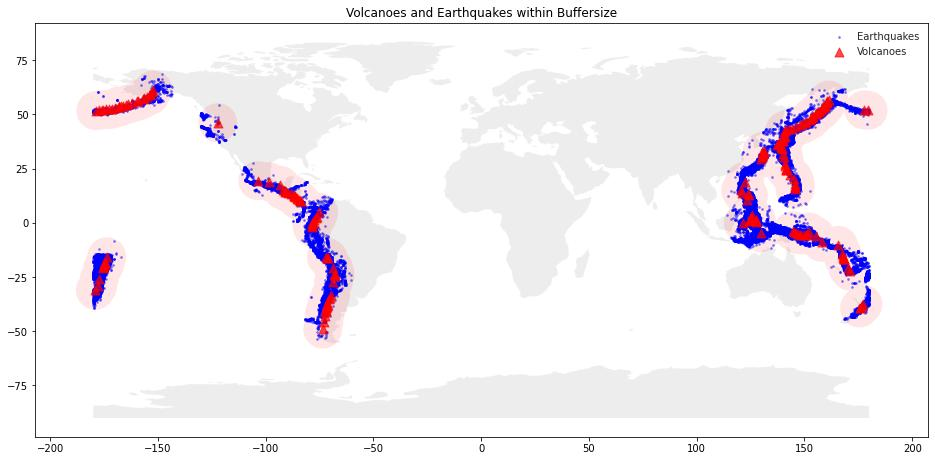

In [18]:
# show the complete results (volcanoes & earthquakes)
fig, ax = plt.subplots(figsize=(16, 10))
plt.style.use('seaborn-whitegrid')
world.plot(ax=ax, color="#dddddd", edgecolor=None, alpha=0.5)
gpd.GeoSeries([volcano_buffers_combined]).plot(ax=ax, color='red', alpha=0.1, edgecolor=None, label='Buffer')
earthquakes_spatially_selected_gdf.plot(ax=ax, color='blue', marker='o', label='Earthquakes', markersize=3, alpha=0.4)
volcanoes_selected_gdf.plot(ax=ax, markersize=80, color='red', alpha=0.7, label='Volcanoes', marker='^')
plt.title('Volcanoes and Earthquakes within Buffersize')
plt.legend()
plt.savefig(os.path.join(data_dir_cluster, "25_Buffered_Earthquakes.png"), format='png', dpi=150, bbox_inches='tight')
logging.info(f"{script_name}: Saving 25_Buffered_Earthquakes.png to './{data_dir_cluster}'.")
plt.show()

In [19]:
# infos of the spatially selected dataset
print("\nShape:\n" + str(earthquakes_spatially_selected_gdf.shape))
print("\nColumns and DataTypes:\n" + str(earthquakes_spatially_selected_gdf.dtypes))
display(earthquakes_spatially_selected_gdf)


Shape:
(55904, 20)

Columns and DataTypes:
id                  object
geo_x              float64
geo_y              float64
timeymd     datetime64[ns]
year                 int64
lon                float64
lat                float64
depth              float64
mag                float64
time                 int64
felt               float64
cdi                float64
mmi                float64
alert               object
status              object
tsunami              int64
nst                  int64
net                 object
sig                float64
geometry          geometry
dtype: object


,id,geo_x,geo_y,timeymd,year,lon,lat,depth,mag,time,felt,cdi,mmi,alert,status,tsunami,nst,net,sig,geometry
0,iscgem799554,276.6450,8.5430,1970-01-01,1970,-83.3550,8.5430,15.00,5.44,6226830,NaN,NaN,NaN,NaN,reviewed,0,455,iscgem,NaN,POINT (-83.35500 8.54300)
1,iscgem799588,182.8310,-29.4000,1970-01-01,1970,-177.1690,-29.4000,35.00,5.61,61860630,NaN,NaN,NaN,NaN,reviewed,0,484,iscgem,NaN,POINT (-177.16900 -29.40000)
2,iscgem799702,121.9190,0.3120,1970-01-04,1970,121.9190,0.3120,146.40,5.54,289882530,NaN,NaN,NaN,NaN,reviewed,0,472,iscgem,NaN,POINT (121.91900 0.31200)
6,iscgem799727,121.1660,19.2160,1970-01-05,1970,121.1660,19.2160,17.50,5.55,346812010,NaN,NaN,NaN,NaN,reviewed,0,474,iscgem,NaN,POINT (121.16600 19.21600)
9,iscgem799772,151.4930,-9.5830,1970-01-06,1970,151.4930,-9.5830,15.00,6.16,452154790,NaN,NaN,5.677,NaN,reviewed,0,584,iscgem,NaN,POINT (151.49300 -9.58300)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63767,us70006s0k,182.4382,-30.3893,2019-12-28,2019,-177.5618,-30.3893,10.00,5.20,1577573355959,1.0,1.0,NaN,NaN,reviewed,0,416,us,NaN,POINT (-177.56180 -30.38930)
63769,us70006s54,125.3963,4.6867,2019-12-29,2019,125.3963,4.6867,23.96,5.40,1577610735869,NaN,NaN,3.748,green,reviewed,0,449,us,NaN,POINT (125.39630 4.68670)
63770,us70006s6z,151.7733,-5.5011,2019-12-29,2019,151.7733,-5.5011,35.00,5.10,1577627942410,NaN,NaN,NaN,NaN,reviewed,0,400,us,NaN,POINT (151.77330 -5.50110)
63771,us70006sbu,142.8218,27.8371,2019-12-30,2019,142.8218,27.8371,17.30,5.10,1577679070184,1.0,3.4,NaN,NaN,reviewed,0,400,us,NaN,POINT (142.82180 27.83710)


## Save data

In [ ]:
# save spatially selected earthquake dataset (for this cluster)
save_dataset(data_file = "earthquakes_spatially_selected.csv", 
             data_dir = data_dir_cluster, 
             data_set = earthquakes_spatially_selected_gdf,
             append_datetime=True,
             overwrite_file=False
            )  
# save spatially selected earthquake dataset (for this cluster)
save_dataset(data_file = "earthquakes_spatially_selected.csv", 
             data_dir = data_dir_cluster, 
             data_set = earthquakes_spatially_selected_gdf,
             append_datetime=False,
             overwrite_file=True
            )  

# save spatially selected earthquake dataset (for this cluster)
save_dataset(data_file = "volcanoes_spatially_selected.csv", 
             data_dir = data_dir_cluster, 
             data_set = volcanoes_selected_gdf,
             append_datetime=True,
             overwrite_file=False
            )  
# save spatially selected earthquake dataset (for this cluster)
save_dataset(data_file = "volcanoes_spatially_selected.csv", 
             data_dir = data_dir_cluster, 
             data_set = volcanoes_selected_gdf,
             append_datetime=False,
             overwrite_file=True
            )  

# save spatially selected earthquake dataset (for this cluster)
save_dataset(data_file = "eruptions_spatially_selected.csv", 
             data_dir = data_dir_cluster, 
             data_set = eruptions_selected,
             append_datetime=True,
             overwrite_file=False
            )# save spatially selected earthquake dataset (for this cluster)
save_dataset(data_file = "eruptions_spatially_selected.csv", 
             data_dir = data_dir_cluster, 
             data_set = eruptions_selected,
             append_datetime=False,
             overwrite_file=True
            )

## End of script

In [ ]:
# log the end of this script
logging.info(f"End of script '{script_name}'.")

## Appendix

In [ ]:
%%js

// -------------------------------------------
// What are the headings of this document?
// --> Get a better overview of the structure.
// -------------------------------------------

function listHeadings() {
    let headings = [];
    let cells = Jupyter.notebook.get_cells();
    
    cells.forEach((cell) => {
        if (cell.cell_type == 'markdown') {
            let text = cell.get_text();
            let lines = text.split('\n');
            
            lines.forEach((line) => {
                let match = line.match(/^(#+)\s+(.*)/);
                if (match) {
                    headings.push({
                        level: match[1].length, // Number of # symbols indicates the heading level
                        text: match[2].trim()
                    });
                }
            });
        }
    });
    return headings;
}

let headings = listHeadings();
headings.forEach((heading) => {
    let markdown = `${'#'.repeat(heading.level)} ${heading.text}`;
    element.append(`${markdown}<br>`);
});

## Save notebook as experimentation protocol

In [ ]:
# save notebook as a experimentation protocol
time.sleep(2)
display(Javascript('IPython.notebook.save_checkpoint();'))
time.sleep(2)
save_notebook_as_html(script_name, data_dir_cluster)